In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
  
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# import cv2
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import argparse

from yolov3.Model import YOLOv3, YOLO_LOSS
from yolov3.Transform import train_transform, test_transform
from yolov3.Datasets import Dataset
from yolov3.Utills import (load_checkpoint, 
                    ANCHORS, 
                    iou, 
                    s, 
                    convert_cells_to_bboxes, 
                    nms, 
                    plot_image, save_image)

device = "cuda" if torch.cuda.is_available() else "cpu"

ImportError: attempted relative import with no known parent package

### EXPORE DATASET

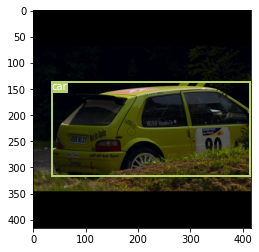

In [8]:
dataset = Dataset(
    csv_file ="train.csv",
    image_dir="images/",
    label_dir="labels/",
    grid_sizes=[13, 26, 52],
    anchors=ANCHORS,
    transform=test_transform
)
  
loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=1,
    shuffle=True,
)
  
GRID_SIZE = [13, 26, 52]
scaled_anchors = torch.tensor(ANCHORS) / (1 / torch.tensor(GRID_SIZE).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))
  
x, y = next(iter(loader))
  
boxes = []
for i in range(y[0].shape[1]):
    anchor = scaled_anchors[i]
    boxes += convert_cells_to_bboxes(y[i], is_predictions=False, s=y[i].shape[2], anchors=anchor)[0]

boxes = nms(boxes, iou_threshold=1, threshold=0.7)
  
plot_image(x[0].permute(1,2,0).to("cpu"), boxes)

### TRAINING PROCESS

In [ ]:
from yolov3.Trainer import training_loop
from yolov3.Utills import save_checkpoint

lr = 1e-5
batch_size = 8
epochs = 50
save_model = True

model = YOLOv3().to(device)
optimizer = optim.Adam(model.parameters(), lr = lr)
loss_fn = YOLO_LOSS()
scaler = torch.cuda.amp.GradScaler()

train_dataset = Dataset(
    csv_file="./train.csv",
    image_dir="./images/",
    label_dir="./labels/",
    anchors=ANCHORS,
    transform=train_transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    num_workers = 0,
    shuffle = True,
    pin_memory = True,
)

scaled_anchors = (
    torch.tensor(ANCHORS) * 
    torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2)
).to(device)

for e in range(1, epochs+1):
    print("Epoch:", e)
    training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
  
    if save_model:
        save_checkpoint(model, optimizer, filename=f"./checkpoint/checkpoint.pth.tar")

Epoch: 1


100% 2069/2069 [06:40<00:00,  5.16it/s, loss=9.49]


==> Saving checkpoint
Epoch: 2


100% 2069/2069 [06:41<00:00,  5.15it/s, loss=7.74]


==> Saving checkpoint
Epoch: 3


100% 2069/2069 [06:39<00:00,  5.18it/s, loss=7.06]


==> Saving checkpoint
Epoch: 4


100% 2069/2069 [06:38<00:00,  5.19it/s, loss=6.47]


==> Saving checkpoint
Epoch: 5


100% 2069/2069 [06:38<00:00,  5.20it/s, loss=5.97]


==> Saving checkpoint
Epoch: 6


100% 2069/2069 [06:40<00:00,  5.17it/s, loss=5.52]


==> Saving checkpoint
Epoch: 7


100% 2069/2069 [06:37<00:00,  5.20it/s, loss=5.13]


==> Saving checkpoint
Epoch: 8


 93% 1919/2069 [06:10<00:31,  4.84it/s, loss=4.78]